### 2. Logistic Regression

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
sb.set() # set the default Seaborn style for graphics

In [2]:
movieData = pd.read_csv('cleaned-movie-dataset.csv')

<Axes: >

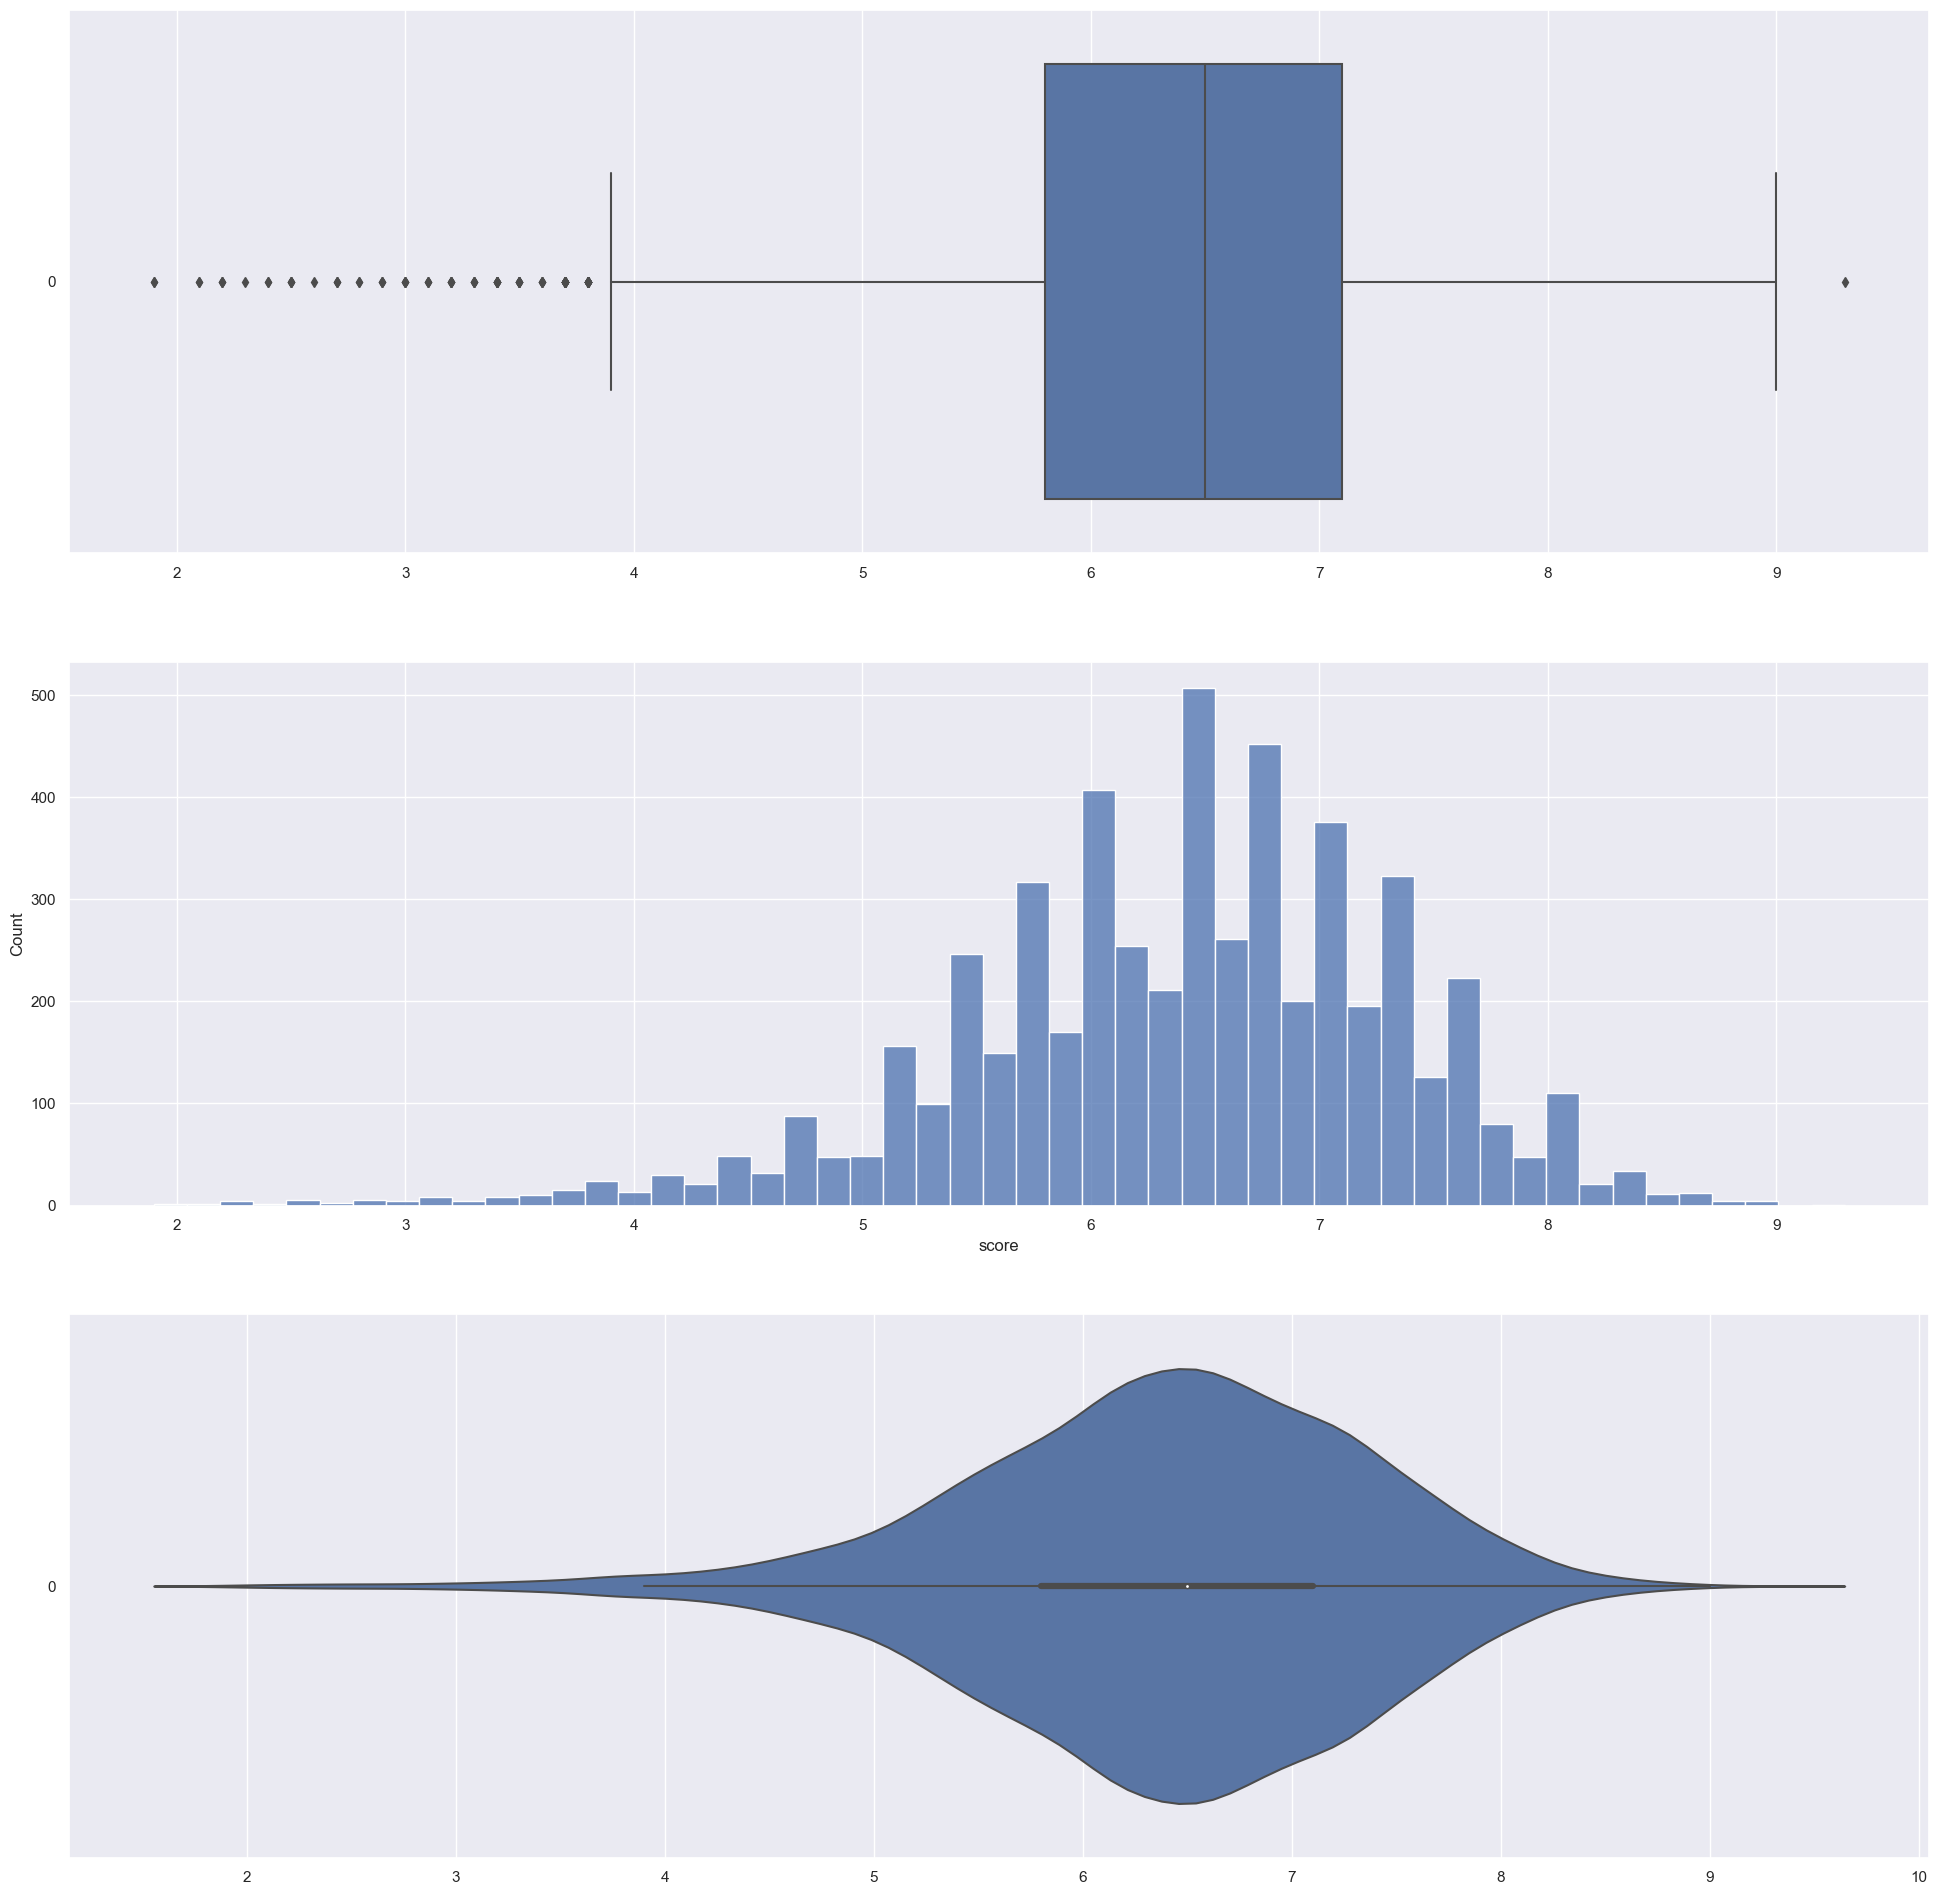

In [3]:
f, axes = plt.subplots(3,figsize=(24, 24))
sb.boxplot(data = movieData["score"], orient = "h", ax = axes[0])
sb.histplot(data = movieData["score"],ax = axes[1])
sb.violinplot(data = movieData["score"], orient = "h", ax = axes[2])

We decided to convert the continuous "score" variable into a categorical variable that indicates if a movie is "successful". We chose the 80th percentile as the cutoff for success since this cutoff captures movies that perform significantly better than the majority while avoiding extreme outliers. 

The 80th percentile value was found to be 7.2 so if the score of the movie is equal to or more than 7.2, we categorized it as a "sucessful" movie.

In [4]:
np.percentile(movieData["score"],80)

7.2

In [5]:
(movieData["score"] >= 7.2).value_counts()

False    4231
True     1192
Name: score, dtype: int64

In [6]:
movieData.head()

,gross,runtime,budget,votes,country,genre,rating,score
0,46998772.0,146.0,19000000.0,927000.0,United Kingdom,Drama,R,8.4
1,58853106.0,104.0,4500000.0,65000.0,United States,Adventure,R,5.8
2,538375067.0,124.0,18000000.0,1200000.0,United States,Action,PG,8.7
3,83453539.0,88.0,3500000.0,221000.0,United States,Comedy,PG,7.7
4,39846344.0,98.0,6000000.0,108000.0,United States,Comedy,R,7.3


The dataset is split into predictor variables (X) and the target variable (y). Our predictor variables are encoded using one-hot encoding to convert categorical variables into a format suitable for logistic regression. The target variable y score is transformed to represent whether a movie is "successful" (1) or not (0) based on the defined threshold, 7.2. The dataset is then split into training and testing sets, with 80% for training and 20% for testing.

In [7]:
# Split the DataFrame into predictors and response
X, y = movieData.iloc[:, :-1], movieData.iloc[:, -1]

X_encoded = pd.get_dummies(X)

# Define 'successful' as score >= 7.2
y = (y >= 7.2).astype('int64')

# Split the dataset into 80% train and 20% test set
# Set random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.8)

# Print the proportion of 'successful' vs. 'not successful' movies in the train set
print("successful vs Not successful Movies Train Set Proportion")
print(y_train.value_counts()[1], ':', y_train.value_counts()[0])


successful vs Not successful Movies Train Set Proportion
967 : 3371


In [8]:
movieData_df = pd.concat([X_train, y_train], axis=1).rename(columns={'score': 'is_successful'})
movieData_df.head()

,gross,runtime,budget,votes,country_Argentina,country_Aruba,country_Australia,country_Austria,country_Belgium,country_Brazil,...,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,rating_TV-MA,rating_Unrated,rating_X,is_successful
1559,19075720.0,96.0,26000000.0,68000.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5300,93320380.0,90.0,35000000.0,19000.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1762,48102795.0,123.0,40000000.0,11000.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2087,4714658.0,100.0,5000000.0,7800.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3046,9448644.0,88.0,20000000.0,30000.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Classification of train by Logistic Regression

Logistic regression is applied to classify movies as "successful" or not based on the predictor variables. The logistic regression model is trained using the training data (X_train and y_train). The overall classification accuracy of the model is calculated on the testing data (X_test and y_test). This accuracy metric provides an indication of how well the model performs in predicting the success of movies based on the chosen features.

In [9]:
from sklearn.model_selection import train_test_split

# Assign x and y value
X = movieData_df.drop(['is_successful'], axis=1)  # Features
y = movieData_df['is_successful']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#Calculate the odds of a movie being successful
print("The odds of a movie being successful in train dataset is: ", y_train.value_counts()[1]/y_train.value_counts()[0])

#Perform the logistics regression
logreg1 = LogisticRegression()
 
#Fit the data
logreg1.fit(X_train,y_train)

#Print out the mean acuuracy
print("The overall classification accuracy \t\t\t: ", logreg1.score(X_test,y_test))

The odds of a movie being successful in train dataset is:  0.2899628252788104
The overall classification accuracy 			:  0.8375576036866359


In [11]:
# Function to calculate all rates
def calculate_rates(cf):
    tp = cf[1, 1]
    fn = cf[1, 0]
    fp = cf[0, 1]
    tn = cf[0, 0]
    
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0.0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0.0
    
    return tpr, tnr, fpr, fnr

# Function to visualize predictions
# Function to visualize predictions
def visualize_preds(table, y_true, y_pred, title):
    f = plt.figure(figsize=(10, 8))
    cf = confusion_matrix(y_true, y_pred)
    sb.heatmap(cf, fmt='.0f', annot=True)

    # Calculate metrics
    accuracy = np.trace(cf) / float(np.sum(cf))
    if sum(cf[:, 1]) == 0:
        precision = 0.0
    else:
        precision = cf[1, 1] / sum(cf[:, 1])
    recall = cf[1, 1] / (cf[1, 1] + cf[1, 0])
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

    # Calculate rates
    tpr, tnr, fpr, fnr = calculate_rates(cf)
    
    stats_text = f'\n\nAccuracy={accuracy:.2f}\nPrecision={precision:.2f}\nRecall={recall:.2f}\nF1 Score={f1_score:.2f}'
    rate_text = f'\n\nTPR={tpr:.2f}, \nTNR={tnr:.2f}, \nFPR={fpr:.2f}, \nFNR={fnr:.2f}'
    plt.xlabel('Predicted' + stats_text + rate_text)
    plt.ylabel('Actual')
    plt.title(title)


    return table




In [12]:
table1 = pd.DataFrame()
table2 = pd.DataFrame()

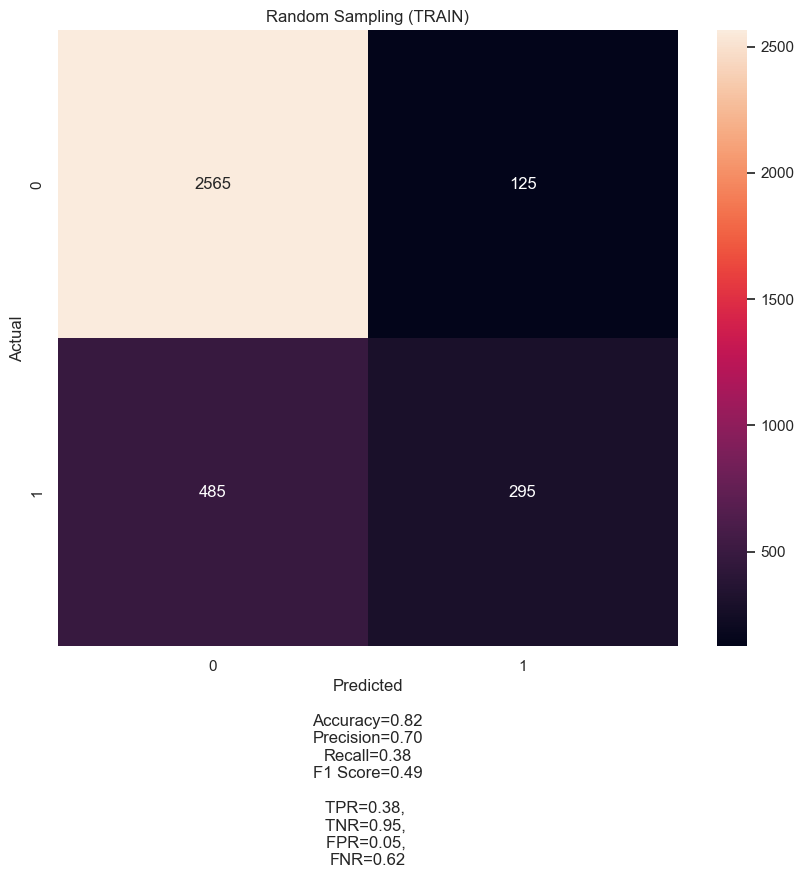

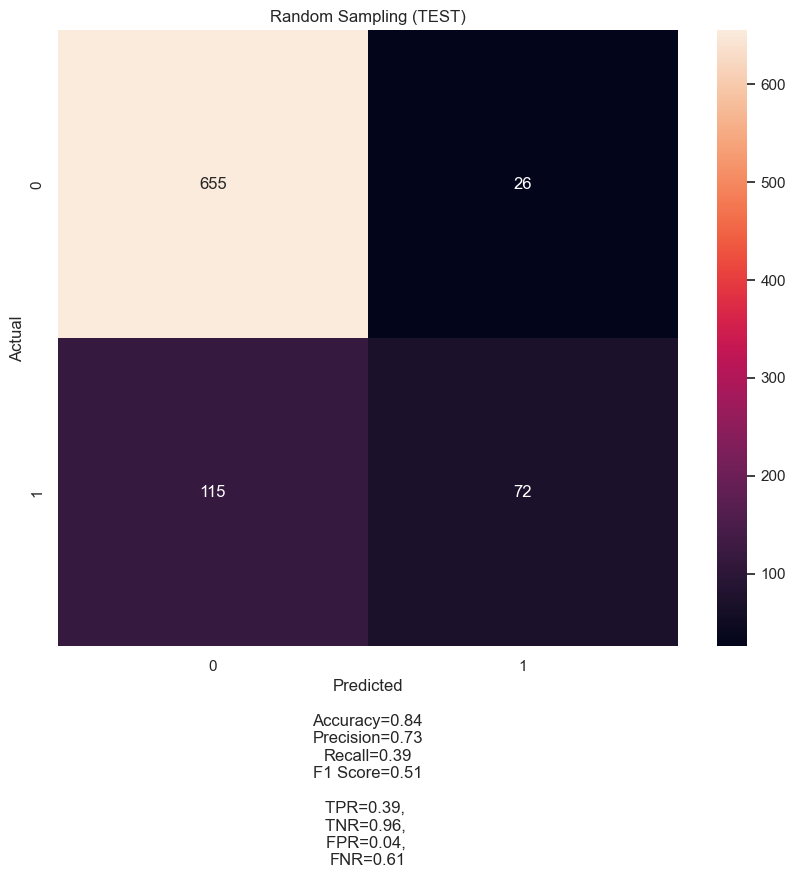

In [13]:
#Predict the data
y_train_pred = logreg1.predict(X_train)
y_test_pred = logreg1.predict(X_test)

#Visualizing the data
table1 = visualize_preds(table1,y_train,y_train_pred, title = 'Random Sampling (TRAIN)')
table2 = visualize_preds(table2,y_test,y_test_pred, title = 'Random Sampling (TEST)')

#### METRICS USED:

1. **Accuracy**: Measures the overall correctness of predictions.

2. **Precision**: Measures the accuracy of positive predictions.

3. **Recall (Sensitivity)**: Measures the completeness of positive predictions.

4. **F1 Score**: Balances precision and recall for a single metric.

These metrics help evaluate how well a classification model performs in terms of making correct predictions and minimizing errors.

For all these scores the higher, the better. 

The model shows reasonably good performance on both the training and test sets. It achieves a relatively high accuracy on both sets, indicating that it correctly predicts the class labels for a large portion of the instances. The precision values suggest that the model makes positive predictions with moderate confidence, and the recall values indicate that it captures a substantial portion of the true positive instances. 

Comparing the performance between the training and test sets, the model demonstrates similar accuracy and F1 scores, indicating that it generalizes reasonably well to unseen data. However, there are very slight differences in precision and recall between the two sets, suggesting some variation in the model's performance on unseen data compared to the training data.

Overall, the model's performance is promising.

## Comparison between statistical models

The Random Forest Regression model initially exhibits a high training R^2 score, indicating a strong fit to the training data. However, this model demonstrates a lower testing R^2 score, suggesting potential overfitting and suboptimal performance on unseen data. Despite efforts to remove outliers and optimize hyperparameters, the model's predictive capability remains limited, as evidenced by the relatively low R^2 scores and consistent error metrics.

In contrast, the Logistic Regression model showcases a more balanced performance between the training and test sets. The Logistic Regression model's performance generalizes reasonably well to unseen data, as evidenced by similar accuracy and F1 scores between the training and test sets. Additionally, the precision and recall metrics indicate a satisfactory balance between correctly predicting positive instances and capturing true positive instances.

Therefore, based on the comparative analysis, the Logistic Regression model emerges as the better-performing option due to its ability to generalize effectively to unseen data and maintain consistent performance metrics across training and test sets.